# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 5000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
from src.Mydataloader import LoadDataset

In [5]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [6]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None
    
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      RandomHorizontalFlip(p=0.5)
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
      RandomHorizontalFlip(p=0.5)
) 256


## Confirm that the dataset is loaded properly

In [7]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-2.3215e-09, -4.5272e-09, -2.2485e-09])
Shape of y: torch.Size([256]) torch.int64


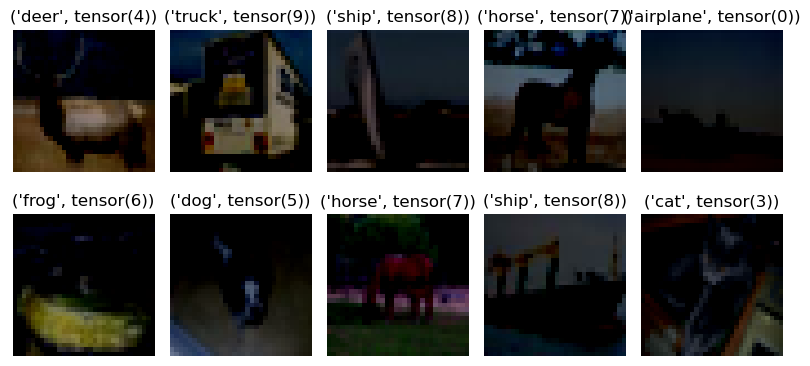

In [8]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [9]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [12]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [13]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [14]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
        # Read checkpoint as desired, e.g.,
        checkpoint = torch.load(
            "logs/" + file_path + ".pth.tar",
            map_location=lambda storage, loc: storage.cuda(device),
        )
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scaler.load_state_dict(checkpoint["scaler"])
        logs = checkpoint["logs"]

        print("Suceessfully loaded the All setting and Log file.")
        print(file_path)
        print(f"Current epoch is {len(logs['train_loss'])}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")        
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")
    

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD
Current epoch is 4509
Current learning rate: 0.1


# [Training Loop]

In [18]:
from src.Mytraining import DoTraining

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 4510/5000] :


100%|██████████| 196/196 [00:05<00:00, 34.48it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.4756 | Test Acc: 88.11%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4511/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.79it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.6013 | Test Acc: 86.74%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4512/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.64it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5693 | Test Acc: 86.53%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4513/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.29it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5429 | Test Acc: 87.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4514/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.88it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.4887 | Test Acc: 88.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4515/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.74it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.4465 | Test Acc: 89.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4516/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.47it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.4887 | Test Acc: 88.19%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4517/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.30it/s]


Train Loss: 0.0004 | Train Acc: 97.50%
Test  Loss: 0.4959 | Test Acc: 87.89%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4518/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.57it/s]


Train Loss: 0.0006 | Train Acc: 95.00%
Test  Loss: 0.4899 | Test Acc: 87.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4519/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.93it/s]


Train Loss: 0.0004 | Train Acc: 95.00%
Test  Loss: 0.4827 | Test Acc: 88.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4520/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.50it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.5683 | Test Acc: 86.59%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4521/5000] :


100%|██████████| 196/196 [00:06<00:00, 32.41it/s]


Train Loss: 0.0003 | Train Acc: 98.75%
Test  Loss: 0.5270 | Test Acc: 87.67%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4522/5000] :


100%|██████████| 196/196 [00:06<00:00, 28.80it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.4755 | Test Acc: 88.78%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4523/5000] :


100%|██████████| 196/196 [00:06<00:00, 28.46it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.4674 | Test Acc: 88.73%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4524/5000] :


100%|██████████| 196/196 [00:07<00:00, 27.94it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.5311 | Test Acc: 87.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4525/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.86it/s]


Train Loss: 0.0010 | Train Acc: 97.50%
Test  Loss: 0.5734 | Test Acc: 87.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4526/5000] :


100%|██████████| 196/196 [00:06<00:00, 28.39it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.6022 | Test Acc: 85.53%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4527/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.99it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5429 | Test Acc: 87.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4528/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.50it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.5207 | Test Acc: 87.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4529/5000] :


100%|██████████| 196/196 [00:05<00:00, 35.79it/s]


Train Loss: 0.0005 | Train Acc: 95.00%
Test  Loss: 0.5234 | Test Acc: 87.02%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4530/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.19it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.5056 | Test Acc: 87.99%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4531/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.86it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.5850 | Test Acc: 86.58%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4532/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.51it/s]


Train Loss: 0.0001 | Train Acc: 97.50%
Test  Loss: 0.5474 | Test Acc: 86.94%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4533/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.17it/s]


Train Loss: 0.0008 | Train Acc: 93.75%
Test  Loss: 0.5206 | Test Acc: 87.70%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4534/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.72it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5864 | Test Acc: 86.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4535/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.91it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.4821 | Test Acc: 88.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4536/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.35it/s]


Train Loss: 0.0004 | Train Acc: 97.50%
Test  Loss: 0.5166 | Test Acc: 88.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4537/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.45it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.4623 | Test Acc: 88.62%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4538/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.76it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.5051 | Test Acc: 88.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4539/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.19it/s]


Train Loss: 0.0002 | Train Acc: 97.50%
Test  Loss: 0.5096 | Test Acc: 87.86%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4540/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.79it/s]


Train Loss: 0.0006 | Train Acc: 97.50%
Test  Loss: 0.5122 | Test Acc: 87.58%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4541/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.16it/s]


Train Loss: 0.0005 | Train Acc: 97.50%
Test  Loss: 0.5279 | Test Acc: 87.78%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4542/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.25it/s]


Train Loss: 0.0004 | Train Acc: 97.50%
Test  Loss: 0.4698 | Test Acc: 88.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4543/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.18it/s]


Train Loss: 0.0004 | Train Acc: 96.25%
Test  Loss: 0.5303 | Test Acc: 87.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4544/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.43it/s]


Train Loss: 0.0004 | Train Acc: 97.50%
Test  Loss: 0.4863 | Test Acc: 88.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4545/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.50it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5787 | Test Acc: 86.83%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4546/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.14it/s]


Train Loss: 0.0004 | Train Acc: 95.00%
Test  Loss: 0.4919 | Test Acc: 88.13%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4547/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.33it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.4917 | Test Acc: 88.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4548/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.43it/s]


Train Loss: 0.0003 | Train Acc: 98.75%
Test  Loss: 0.5035 | Test Acc: 87.92%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4549/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.03it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.4938 | Test Acc: 88.67%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4550/5000] :


100%|██████████| 196/196 [00:05<00:00, 32.99it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.5238 | Test Acc: 87.75%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4551/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.25it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.6192 | Test Acc: 86.66%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4552/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.12it/s]


Train Loss: 0.0006 | Train Acc: 95.00%
Test  Loss: 0.5024 | Test Acc: 87.75%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4553/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.75it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.5445 | Test Acc: 86.90%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4554/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.68it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.4866 | Test Acc: 88.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4555/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.02it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5044 | Test Acc: 87.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4556/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.35it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.6043 | Test Acc: 86.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4557/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.5236 | Test Acc: 87.78%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4558/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.21it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.4985 | Test Acc: 88.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4559/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.18it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.5256 | Test Acc: 87.91%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4560/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.77it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.6218 | Test Acc: 86.61%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4561/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.69it/s]


Train Loss: 0.0002 | Train Acc: 97.50%
Test  Loss: 0.5500 | Test Acc: 87.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4562/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.56it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5465 | Test Acc: 87.84%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4563/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.23it/s]


Train Loss: 0.0003 | Train Acc: 98.75%
Test  Loss: 0.5120 | Test Acc: 87.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4564/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.61it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.5354 | Test Acc: 87.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4565/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.41it/s]


Train Loss: 0.0006 | Train Acc: 97.50%
Test  Loss: 0.4675 | Test Acc: 88.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4566/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.64it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5233 | Test Acc: 87.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4567/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.68it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.4995 | Test Acc: 88.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4568/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.54it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.5077 | Test Acc: 87.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4569/5000] :


100%|██████████| 196/196 [00:06<00:00, 32.23it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.5324 | Test Acc: 86.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4570/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.03it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.5360 | Test Acc: 87.86%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4571/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.38it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.5328 | Test Acc: 87.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4572/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.29it/s]


Train Loss: 0.0004 | Train Acc: 95.00%
Test  Loss: 0.5619 | Test Acc: 87.19%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4573/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.47it/s]


Train Loss: 0.0003 | Train Acc: 97.50%
Test  Loss: 0.5321 | Test Acc: 87.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4574/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.66it/s]


Train Loss: 0.0004 | Train Acc: 97.50%
Test  Loss: 0.5363 | Test Acc: 87.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4575/5000] :


100%|██████████| 196/196 [00:06<00:00, 31.49it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.4858 | Test Acc: 88.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4576/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.77it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.5057 | Test Acc: 88.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4577/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.4926 | Test Acc: 88.58%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4578/5000] :


100%|██████████| 196/196 [00:06<00:00, 28.50it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.7059 | Test Acc: 84.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4579/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.87it/s]


Train Loss: 0.0002 | Train Acc: 98.75%
Test  Loss: 0.5681 | Test Acc: 86.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4580/5000] :


100%|██████████| 196/196 [00:06<00:00, 29.32it/s]


Train Loss: 0.0002 | Train Acc: 97.50%
Test  Loss: 0.5325 | Test Acc: 87.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4581/5000] :


100%|██████████| 196/196 [00:06<00:00, 32.42it/s]


Train Loss: 0.0005 | Train Acc: 97.50%
Test  Loss: 0.5005 | Test Acc: 87.87%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4582/5000] :


100%|██████████| 196/196 [00:06<00:00, 30.86it/s]


Train Loss: 0.0001 | Train Acc: 98.75%
Test  Loss: 0.5529 | Test Acc: 86.55%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 4583/5000] :


  8%|▊         | 16/196 [00:00<00:08, 22.19it/s]


KeyboardInterrupt: 

## Training Results

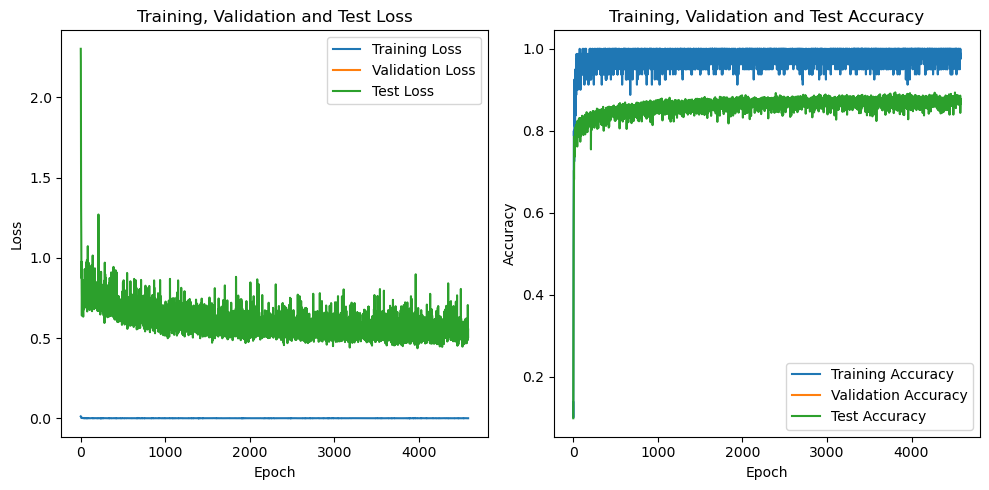

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [21]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

4582
4582
0
0
4582
4582


- 주피터노트북 output set
- @tag:notebookOutputLayout

In [22]:
for i in range(len(logs["train_loss"])):
    print(
        f"{i+1} epoch: train_loss={logs['train_loss'][i]:.4f}, train_acc={logs['train_acc'][i]:.4f}, test_loss={logs['test_loss'][i]:.4f}, test_acc={logs['test_acc'][i]:.4f}"
    )

1 epoch: train_loss=0.0118, train_acc=0.1375, test_loss=2.3033, test_acc=0.0987
2 epoch: train_loss=0.0112, train_acc=0.1000, test_loss=2.2203, test_acc=0.1732
3 epoch: train_loss=0.0089, train_acc=0.3750, test_loss=1.7736, test_acc=0.3604
4 epoch: train_loss=0.0062, train_acc=0.5500, test_loss=1.6408, test_acc=0.4267
5 epoch: train_loss=0.0053, train_acc=0.5875, test_loss=1.3253, test_acc=0.5186
6 epoch: train_loss=0.0048, train_acc=0.7125, test_loss=1.2669, test_acc=0.5648
7 epoch: train_loss=0.0047, train_acc=0.6750, test_loss=1.1324, test_acc=0.6224
8 epoch: train_loss=0.0032, train_acc=0.8000, test_loss=1.0242, test_acc=0.6489
9 epoch: train_loss=0.0034, train_acc=0.7875, test_loss=0.8742, test_acc=0.7036
10 epoch: train_loss=0.0026, train_acc=0.8000, test_loss=0.9760, test_acc=0.6811
11 epoch: train_loss=0.0029, train_acc=0.7875, test_loss=0.7942, test_acc=0.7365
12 epoch: train_loss=0.0030, train_acc=0.7250, test_loss=0.7726, test_acc=0.7481
13 epoch: train_loss=0.0034, train_ac